In [1]:
# -*- coding: utf-8 -*-
"""
Created on May 17, 2024
Last modified on May 17, 2024
@Author: Guan-Fu Liu

To calculate how the abundance evolves with time with variable IMF
"""
import numpy as np
import pandas as pd
import sys
sys.path.insert(0, '/Users/liuguanfu/Workspace/SAS-21/targets/MRK1216/spex/jupyter/IMF')
import re
import os
import utils
import constants
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy import interpolate
import h5py
from tqdm import tqdm
import time
%matplotlib widget

In [2]:
output_dir = "./outputs/"
solar_set = "Default"
# f =  h5py.File(os.path.join(output_dir, "2024-05-19-21-38.h5"), 'r')  # SNIaOn == True

# old mass lifetime relation
# 2024-05-19-22-10 True
# 2024-05-19-22-16 False

# New mass lifetime relation
# 2024-05-20-16-06 False
# 2024-05-20-16-34 True

# New mass lifetime relation and interpolation of metallicities
# 2024-05-20-18-13 False
# 2024-05-20-18-26 True

# New mass lifetime relation, add stellar mass
# 2024-05-20-21-33 False
# 2024-05-20-21-41 True

# New mass lifetime relation and interpolation of metallicities, add stellar mass
# 2024-05-20-21-58 False
# 2024-05-20-22-13 True

SNIaOn = True
if SNIaOn:
    f =  h5py.File(os.path.join(output_dir, "2024-05-20-22-13.h5"), 'r')  # SNIaOn == True
    dir1 = "1square-SNIaON"
else:
    f =  h5py.File(os.path.join(output_dir, "2024-05-20-21-58.h5"), 'r')  # SNIaOn == False
    dir1 = "1square-SNIaOFF"



###### Load the yield table used in the simulation  ######
yield_files = {a.split()[0]: f.attrs[a] for a in f.attrs.keys() if 'yield file' in a}
files = {key: h5py.File(value, 'r') for key, value in yield_files.items()}
groups = {key: list(files[key].keys()) for key in files.keys()}  # The available metallicity values in yield table
# The available metallicity values in yield table
Zyield = {key: np.array([float(group.split("=")[1]) for group in groups[key]]) for key in groups.keys()}
ElemNotice = list(f.attrs['Concerned Elements'])
# They should appear in the yield table from AGB+SNcc.
# It should contain H, He and Other.
# The finally selected elements are the intersection of ElemNotice and the elements avaliable in the yield table.
# You may as well not to notice too many elements, which will speed down the calculation.
dfs = { }
ElemIntersect = { }
for key in files.keys():
    dfs[key] = { }
    ElemIntersect[key] = { }
    for group in groups[key]:
        if key == "SNIa":
            dfs[key][group] = pd.DataFrame(files[key][group]['Original'][...])
        else:
            dfs[key][group] = pd.DataFrame(files[key][group]['Interpolated'][...])
        dfs[key][group].loc[:, 'M'] = dfs[key][group].loc[:, 'M'].astype(str)
        dfs[key][group].set_index('M', inplace=True)
        index = dfs[key][group].index
        index = [False if a in ElemNotice + ['Mrem'] else True for a in index]
        # Add the mass of the elements not in ElemNotice to the "Other" element
        if "Other" in dfs[key][group].index:
            dfs[key][group].loc["Other"] += dfs[key][group].loc[index].sum(axis=0)
        else:
            dfs[key][group].loc["Other"] = dfs[key][group].loc[index].sum(axis=0)
        ElemIntersect[key][group] = list(set(ElemNotice).intersection(set(dfs[key][group].index)))

for key in files.keys():
    for group in groups[key]:
        if len(set(ElemNotice)-set(ElemIntersect[key][group]))>0:
            print("The elements you notice but not available in the yield table of %s, %s are" %\
                 (key, group), set(ElemNotice)-set(ElemIntersect[key][group]))
            

YieldsTable = f['Gas/YieldsTable'][()]
if f.attrs['SNIaOn'] == 'Yes':
    print("The yields from SNIa are taken into consideration in the result to be analysed.")
    SNIa = True
elif f.attrs['SNIaOn'] == 'No':
    print("The yields from SNIa are ignored in the result to be analysed.")
    SNIa = False
else:
    raise ValueError("The SNIaOFF attribute should be either 'Yes' or 'No'.")

###### Load the yield table used in the simulation  ######

###### Load the Star group ######

SFH = { }
for key in ['Age', 'SFR', 'TimeBin', 'Mstar']:
    SFH[key] = f['Star/'+key][()]

Mstar = f['Star/Mstar'][()]
SNIaNum = f['Star/SNIaNum'][()]
StarInitElement = f['Star/StarInitElement'][()]
StellarMass = f['Star/StellarMass'][()]
###### Load the Star group ######

###### Load the Gas group ######
GasElement = f['Gas/GasElement'][()]
EjectElement = f['Gas/EjectElement'][()]
YieldsTable = f['Gas/YieldsTable'][()]
ZGas = f['Gas/ZGas'][()]
###### Load the Gas group ######
f.close()

The elements you notice but not available in the yield table of SNIa, Z=0.02 are {'C', 'H', 'He', 'N', 'Ca'}
The yields from SNIa are taken into consideration in the result to be analysed.


In [3]:
def GetZi2Zj(GasElement, Zi, Zj, solar_set, fill_value=None):
    """
    To get the ratio of the element j to the element i in the solar unit.

    If the mass of the element j at some ages are zero, the ratio of the element j to the element i is set to fill_value.

    Parameters
    ----------
    GasElement : numpy array
        The mass of elements. The shape of GasElement should be (N, 32). Here N is them number of ages, 32 is the number of elements
        (the first and the last elemen are empty and "others", should not be used).
    Zi : str
        The element i. It should be in the list of constants.elem_names, namely, from H to Zn (Z=1, 2, 3, ..., 30).
    Zj : str
        The element j. It should be in the list of constants.elem_names, namely, from H to Zn (Z=1, 2, 3, ..., 30).
    solar_set : str
        The solar abundance set. It should be in the list of constants.abund_tables.keys().
    fill_value : float or None, optional
        The value to fill the ratio of the element j to the element i if the mass of the element j or the element i is zero.
        If it is None, mask the ages where the mass of the element j is zero, which will change the shape of the output.
        If it is a float, it should be a positive number.

    Returns
    -------
    Zi2Zj: dict
        The ratio of the element j to the element i in the solar unit.
        Zi2Zj['%s/%s'%(Zi, Zj)] is the ratio of the element j to the element i, in the solar unit.
        Zi2Zj['[%s/%s]'%(Zi, Zj)] is log10(Zi2Zj['%s/%s'%(Zi, Zj)]).
        Zi2Zj['%s-mask'%Zj] is the mask of the ages where BOTH of the mass of the element j and i is POSITIVE.
    """
    if Zi not in constants.elem_names or Zj not in constants.elem_names:
        print("The element should be in the list of constants.elem_names, which is ", constants.elem_names)
        return None
    if solar_set not in constants.abund_tables.keys():
        print("The solar abundance set should be in the list of constants.abund_tables.keys(), which is ",
               constants.abund_tables.keys())
        return None
    Zi2Zj_solar = constants.abund_tables[solar_set][constants.elem_names.index(Zi)] / \
                   constants.abund_tables[solar_set][constants.elem_names.index(Zj)]
    mask = GasElement[:, constants.elem_names.index(Zj)] > 0
    mask = mask & (GasElement[:, constants.elem_names.index(Zi)] > 0)
    Zi2Zj = { }
    if fill_value is None:
        Zi2Zj['%s/%s'%(Zi, Zj)] = GasElement[mask, constants.elem_names.index(Zi)] / \
                                  GasElement[mask, constants.elem_names.index(Zj)] / Zi2Zj_solar
        Zi2Zj['[%s/%s]'%(Zi, Zj)] = np.log10(Zi2Zj['%s/%s'%(Zi, Zj)])
    else:
        Zi2Zj['%s/%s'%(Zi, Zj)] = np.zeros(len(GasElement))
        Zi2Zj['%s/%s'%(Zi, Zj)][mask] = GasElement[mask, constants.elem_names.index(Zi)] / \
                                        GasElement[mask, constants.elem_names.index(Zj)] / Zi2Zj_solar
        Zi2Zj['%s/%s'%(Zi, Zj)][~mask] = fill_value
        Zi2Zj['[%s/%s]'%(Zi, Zj)] = np.log10(Zi2Zj['%s/%s'%(Zi, Zj)])
    Zi2Zj['%s/%s-mask'%(Zi,Zj)] = mask
    return Zi2Zj

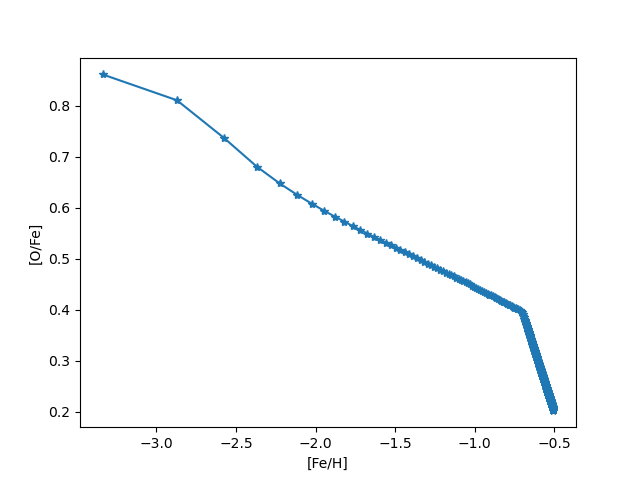

In [4]:
Zi2Zj = { }
Zi = "O"
Zi2Zj.update(GetZi2Zj(GasElement, Zi, "Fe", solar_set, fill_value=None))
Zi2Zj.update(GetZi2Zj(GasElement, "Fe", "H", solar_set, fill_value=None))

fig, ax = plt.subplots()
ax.plot(Zi2Zj["[Fe/H]"], Zi2Zj["[%s/Fe]"%Zi], '-*')
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('[%s/Fe]'%Zi)
plt.show()

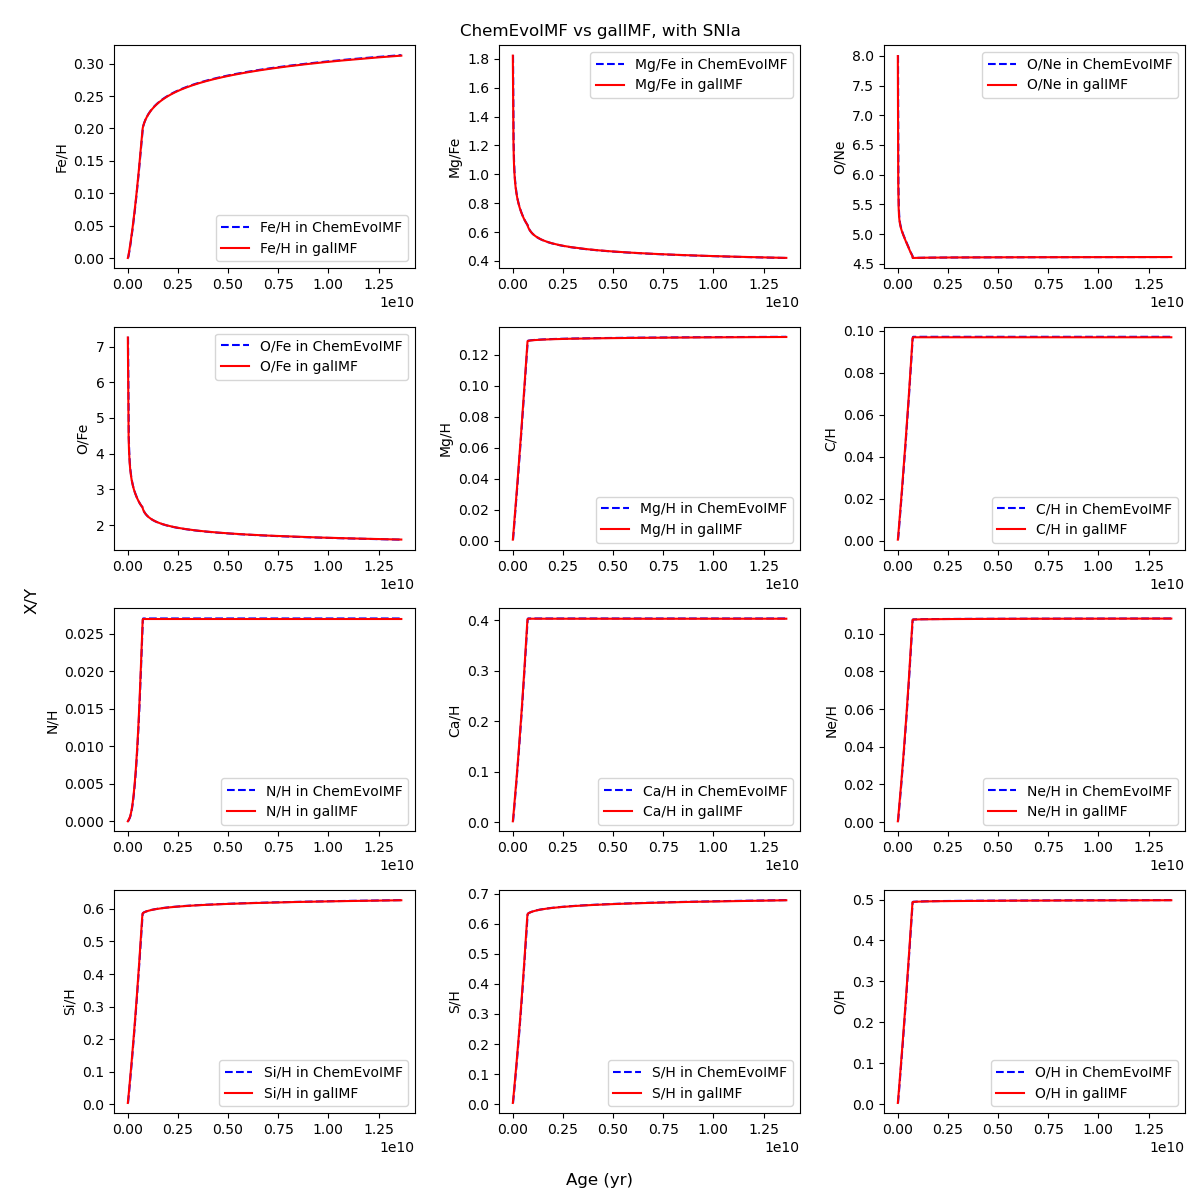

In [20]:
filepath = "../galIMF/simulation_results_from_galaxy_evol/%s/chemical_and_SN_evolution.txt"%dir1
with open(filepath, 'r') as f:
    lines = f.readlines()

Zis = [ ]
Zjs = [ ]
line_num =  [ ]
for i, line in enumerate(lines):
    if "# Gas" in line and "metallicity" not in line:
        elem1, elem2 = re.search(r'\[(\w+)/(\w+)\]', line).groups()
        Zis.append(elem1)
        Zjs.append(elem2)
        line_num.append(i+1)
    elif "time step" in line:
        t = np.array(lines[i+1].split(), dtype=float)
    else:
        pass
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(3*4, 4*3))
axes = axes.flatten()
for idx in range(len(Zis)):
    ax = axes[idx]
    Zi = Zis[idx]
    Zj = Zjs[idx]
    correct_factor = constants.abund_tables["AG"][constants.elem_names.index(Zi)]\
        /constants.abund_tables["AG"][constants.elem_names.index(Zj)]\
        *constants.abund_tables[solar_set][constants.elem_names.index(Zj)]\
        /constants.abund_tables[solar_set][constants.elem_names.index(Zi)]
    Zi2Zj = { }
    Zi2Zj["galIMF-%s/%s"%(Zi,Zj)] = 10**np.array(lines[line_num[idx]].split(), dtype=float)*correct_factor
    Zi2Zj.update(GetZi2Zj(GasElement, Zi, Zj, solar_set, fill_value=None))
    ax.plot(SFH['Age'][Zi2Zj['%s/%s-mask'%(Zi,Zj)]], Zi2Zj['%s/%s'%(Zi,Zj)], 'b--', label='%s/%s in ChemEvoIMF'%(Zi,Zj))
    ax.plot(t, Zi2Zj["galIMF-%s/%s"%(Zi,Zj)], 'r-', label="%s/%s in galIMF"%(Zi,Zj))
    ax.set_ylabel('%s/%s'%(Zi,Zj))
    ax.legend()

fig.supxlabel('Age (yr)')
fig.supylabel('X/Y')

if SNIaOn:
    fig.suptitle("ChemEvoIMF vs galIMF, with SNIa")
    fig.tight_layout()
    fig.savefig("ChemEvoIMF_vs_galIMF_SNIaON.pdf")
else:
    fig.suptitle("ChemEvoIMF vs galIMF, No SNIa")
    fig.tight_layout()
    fig.savefig("ChemEvoIMF_vs_galIMF_SNIaOFF.pdf")
plt.show()

```python
mass_calibration_factor = M_tot_of_this_epoch / integrate_igimf_mass

number_in_SNIa_boundary = mass_calibration_factor * quad(igimf_xi_function, 3, 8, limit=50)[0]

number_all = mass_calibration_factor * quad(igimf_xi_function, 0.1, 100, limit=50)[0]

SNIa_number_prob = number_in_SNIa_boundary ** 2 / number_all / M_tot_of_this_epoch

```

In [6]:
Denominator=4.819420e-04
Numerator=1.575560e-04
print(Numerator/Denominator)

0.3269190068514468


In [7]:
import utils
IMF = utils.IMF(IMF_type='Salpeter')
SNIa = utils.SNIa(IMF.imf)

In [8]:
SNIa.p, dir1

(0.4491511369257616, '1square-SNIaON')

In [9]:
Zis, Zjs

(['Fe', 'Mg', 'O', 'O', 'Mg', 'C', 'N', 'Ca', 'Ne', 'Si', 'S', 'O'],
 ['H', 'Fe', 'Ne', 'Fe', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'])

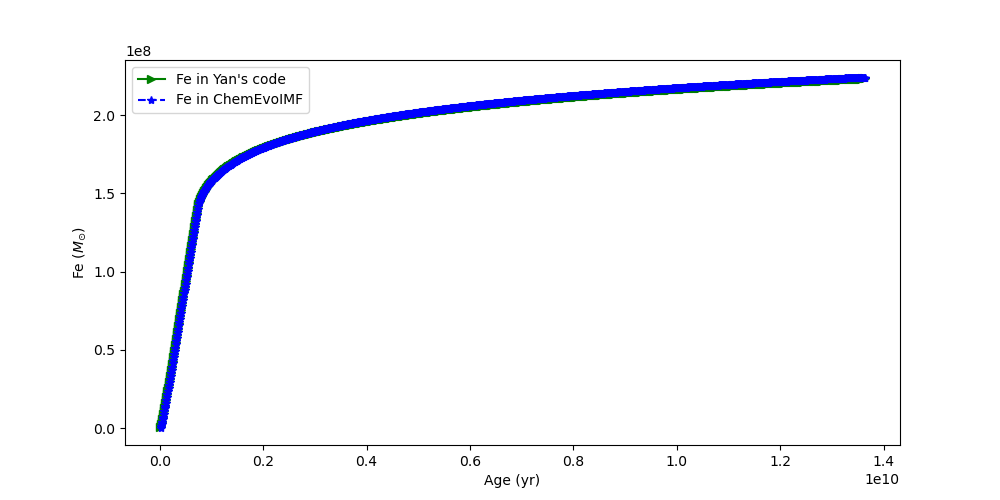

In [10]:
filepath = "../galIMF/simulation_results_from_galaxy_evol/%s/chemical_and_SN_evolution.txt"%dir1
with open(filepath, 'r') as f:
    lines = f.readlines()

Zis = [ ]
Zjs = [ ]
line_num =  [ ]
for i, line in enumerate(lines):
    if "# Gas" in line and "metallicity" not in line:
        elem1, elem2 = re.search(r'\[(\w+)/(\w+)\]', line).groups()
        Zis.append(elem1)
        Zjs.append(elem2)
        line_num.append(i+1)
    elif "time step" in line:
        t = np.array(lines[i+1].split(), dtype=float)
    else:
        pass

Zi = "Fe"
filepath = "../galIMF/simulation_results_from_galaxy_evol/%s/plots/%s.txt" % (dir1, Zi)
with open(filepath, 'r') as f:
    lines = f.readlines()

Zi_arr = { }
Zi_arr[filepath.split("/")[-1].split(".")[0]] = np.array(lines[1].split(), dtype=float)
Zi2Zj.update(GetZi2Zj(GasElement, "Fe", "H", solar_set, fill_value=None))
fig, ax = plt.subplots(ncols=1, figsize=(10, 5))
ax.plot(t, Zi_arr[Zi], 'g->', label="%s in Yan's code"%Zi)
ax.plot(SFH['Age'][Zi2Zj['%s/%s-mask'%(Zi,'H')]], GasElement[Zi2Zj['%s/%s-mask'%(Zi,'H')], constants.elem_names.index(Zi)], 
        'b--*', label='%s in ChemEvoIMF'%Zi)
ax.set_xlabel('Age (yr)')
ax.set_ylabel(r"%s ($M_{\odot}$)"%Zi)
ax.legend()
plt.show()

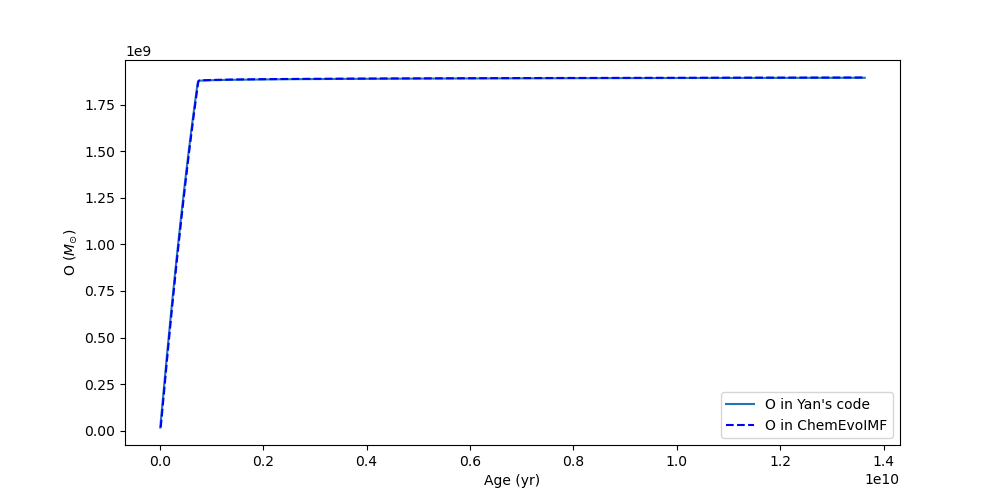

In [11]:
filepath = "../galIMF/simulation_results_from_galaxy_evol/%s/chemical_and_SN_evolution.txt"%dir1
with open(filepath, 'r') as f:
    lines = f.readlines()

Zis = [ ]
Zjs = [ ]
line_num =  [ ]
for i, line in enumerate(lines):
    if "# Gas" in line and "metallicity" not in line:
        elem1, elem2 = re.search(r'\[(\w+)/(\w+)\]', line).groups()
        Zis.append(elem1)
        Zjs.append(elem2)
        line_num.append(i+1)
    elif "time step" in line:
        t = np.array(lines[i+1].split(), dtype=float)
    else:
        pass

Zi = "O"
filepath = "../galIMF/simulation_results_from_galaxy_evol/%s/plots/%s.txt" % (dir1, Zi)
with open(filepath, 'r') as f:
    lines = f.readlines()

Zi_arr = { }
Zi_arr[filepath.split("/")[-1].split(".")[0]] = np.array(lines[1].split(), dtype=float)
Zi2Zj.update(GetZi2Zj(GasElement, Zi, "H", solar_set, fill_value=None))
fig, ax = plt.subplots(ncols=1, figsize=(10, 5))
ax.plot(t, Zi_arr[Zi], label="%s in Yan's code"%Zi)
ax.plot(SFH['Age'][Zi2Zj['%s/%s-mask'%(Zi,'H')]], GasElement[Zi2Zj['%s/%s-mask'%(Zi,'H')], constants.elem_names.index(Zi)], 
        'b--', label='%s in ChemEvoIMF'%Zi)
ax.set_xlabel('Age (yr)')
ax.set_ylabel(r"%s ($M_{\odot}$)"%Zi)
ax.legend()
plt.show()

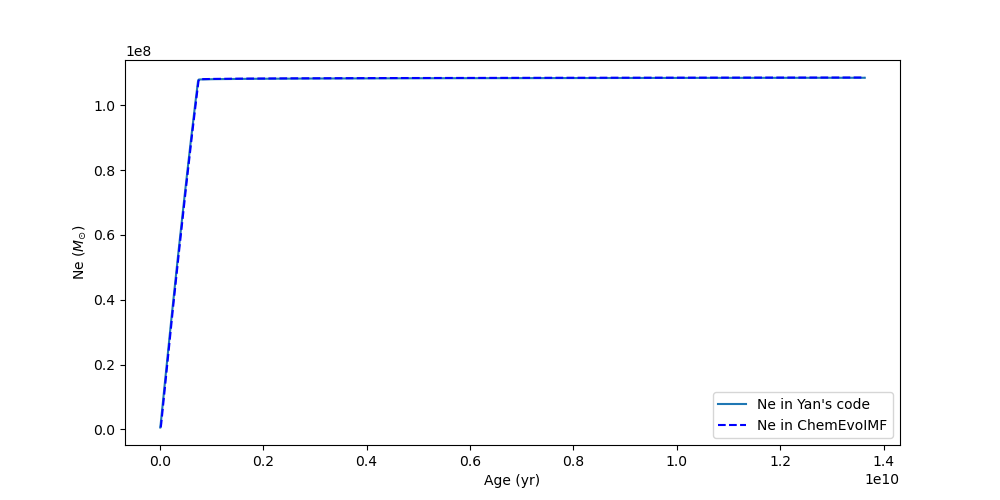

In [12]:
filepath = "../galIMF/simulation_results_from_galaxy_evol/%s/chemical_and_SN_evolution.txt"%dir1
with open(filepath, 'r') as f:
    lines = f.readlines()

Zis = [ ]
Zjs = [ ]
line_num =  [ ]
for i, line in enumerate(lines):
    if "# Gas" in line and "metallicity" not in line:
        elem1, elem2 = re.search(r'\[(\w+)/(\w+)\]', line).groups()
        Zis.append(elem1)
        Zjs.append(elem2)
        line_num.append(i+1)
    elif "time step" in line:
        t = np.array(lines[i+1].split(), dtype=float)
    else:
        pass

Zi = "Ne"
filepath = "../galIMF/simulation_results_from_galaxy_evol/%s/plots/%s.txt" % (dir1, Zi)
with open(filepath, 'r') as f:
    lines = f.readlines()

Zi_arr = { }
Zi_arr[filepath.split("/")[-1].split(".")[0]] = np.array(lines[1].split(), dtype=float)
Zi2Zj.update(GetZi2Zj(GasElement, Zi, "H", solar_set, fill_value=None))
fig, ax = plt.subplots(ncols=1, figsize=(10, 5))
ax.plot(t, Zi_arr[Zi], label="%s in Yan's code"%Zi)
ax.plot(SFH['Age'][Zi2Zj['%s/%s-mask'%(Zi,'H')]], 
        GasElement[Zi2Zj['%s/%s-mask'%(Zi,'H')], constants.elem_names.index(Zi)], 
        'b--', label='%s in ChemEvoIMF'%Zi)
ax.set_xlabel('Age (yr)')
ax.set_ylabel(r"%s ($M_{\odot}$)"%Zi)
ax.legend()
plt.show()

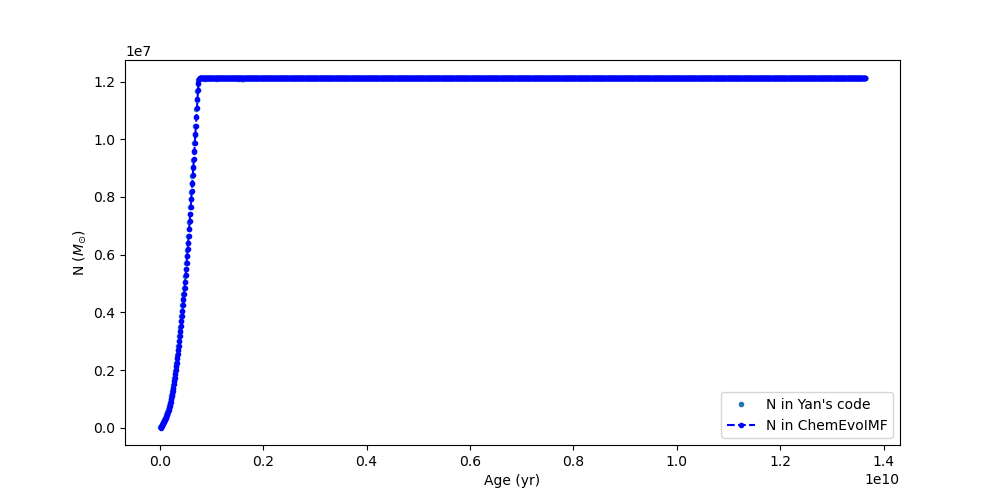

In [13]:
filepath = "../galIMF/simulation_results_from_galaxy_evol/%s/chemical_and_SN_evolution.txt"%dir1
with open(filepath, 'r') as f:
    lines = f.readlines()

Zis = [ ]
Zjs = [ ]
line_num =  [ ]
for i, line in enumerate(lines):
    if "# Gas" in line and "metallicity" not in line:
        elem1, elem2 = re.search(r'\[(\w+)/(\w+)\]', line).groups()
        Zis.append(elem1)
        Zjs.append(elem2)
        line_num.append(i+1)
    elif "time step" in line:
        t = np.array(lines[i+1].split(), dtype=float)
    else:
        pass

Zi = "N"
filepath = "../galIMF/simulation_results_from_galaxy_evol/%s/plots/%s.txt" % (dir1, Zi)
with open(filepath, 'r') as f:
    lines = f.readlines()

Zi_arr = { }
Zi_arr[filepath.split("/")[-1].split(".")[0]] = np.array(lines[1].split(), dtype=float)
Zi2Zj.update(GetZi2Zj(GasElement, Zi, "H", solar_set, fill_value=None))
fig, ax = plt.subplots(ncols=1, figsize=(10, 5))
ax.plot(t, Zi_arr[Zi], '.', label="%s in Yan's code"%Zi)
ax.plot(SFH['Age'][Zi2Zj['%s/%s-mask'%(Zi,'H')]], 
        GasElement[Zi2Zj['%s/%s-mask'%(Zi,'H')], constants.elem_names.index(Zi)], 
        'b--.', label='%s in ChemEvoIMF'%Zi)
ax.set_xlabel('Age (yr)')
ax.set_ylabel(r"%s ($M_{\odot}$)"%Zi)
ax.legend()
plt.show()

In [14]:
Zi_arr[Zi].max()/GasElement[Zi2Zj['%s/%s-mask'%(Zi,'H')], constants.elem_names.index(Zi)].max()

0.9973532554262502

In [15]:
YieldsTable

array([[b'AGB+SNcc: Z=0.0004, SNIa: Z=0.02',
        b'AGB+SNcc: Z=0.0004, SNIa: Z=0.02'],
       [b'AGB+SNcc: Z=0.0004, SNIa: Z=0.02',
        b'AGB+SNcc: Z=0.0004, SNIa: Z=0.02'],
       [b'AGB+SNcc: Z=0.0004, SNIa: Z=0.02',
        b'AGB+SNcc: Z=0.0004, SNIa: Z=0.02'],
       ...,
       [b'No Star Formation', b'No Star Formation'],
       [b'No Star Formation', b'No Star Formation'],
       [b'No Star Formation', b'No Star Formation']], dtype='|S32')

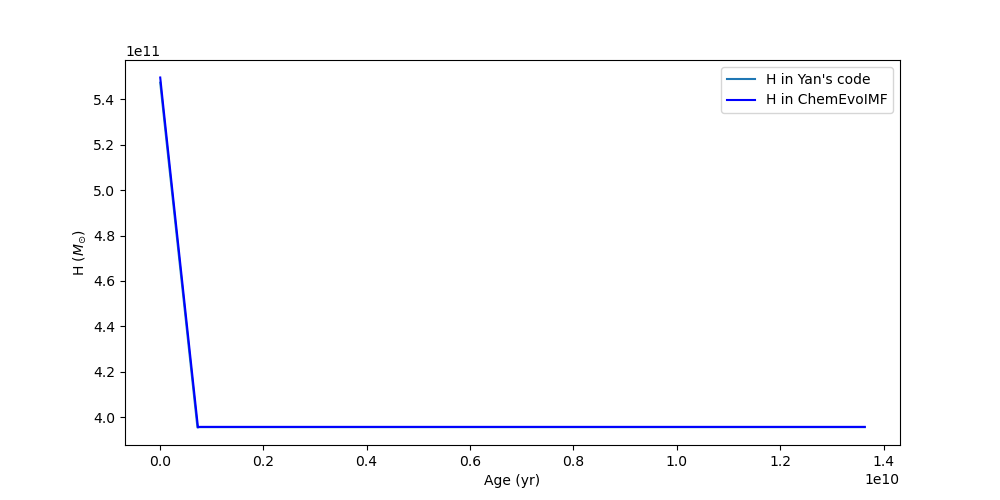

In [16]:
filepath = "../galIMF/simulation_results_from_galaxy_evol/%s/chemical_and_SN_evolution.txt"%dir1
with open(filepath, 'r') as f:
    lines = f.readlines()

Zis = [ ]
Zjs = [ ]
line_num =  [ ]
for i, line in enumerate(lines):
    if "# Gas" in line and "metallicity" not in line:
        elem1, elem2 = re.search(r'\[(\w+)/(\w+)\]', line).groups()
        Zis.append(elem1)
        Zjs.append(elem2)
        line_num.append(i+1)
    elif "time step" in line:
        t = np.array(lines[i+1].split(), dtype=float)
    else:
        pass

Zi = "H"
filepath = "../galIMF/simulation_results_from_galaxy_evol/%s/plots/%s.txt" % (dir1, Zi)
with open(filepath, 'r') as f:
    lines = f.readlines()

Zi_arr = { }
Zi_arr[filepath.split("/")[-1].split(".")[0]] = np.array(lines[1].split(), dtype=float)
Zi2Zj.update(GetZi2Zj(GasElement, Zi, "H", solar_set, fill_value=None))
fig, ax = plt.subplots(ncols=1, figsize=(10, 5))
ax.plot(t, Zi_arr[Zi], label="%s in Yan's code"%Zi)
ax.plot(SFH['Age'][Zi2Zj['%s/%s-mask'%(Zi,'H')]], GasElement[Zi2Zj['%s/%s-mask'%(Zi,'H')], constants.elem_names.index(Zi)], 
        'b-', label='%s in ChemEvoIMF'%Zi)
ax.set_xlabel('Age (yr)')
ax.set_ylabel(r"%s ($M_{\odot}$)"%Zi)
ax.legend()
plt.show()

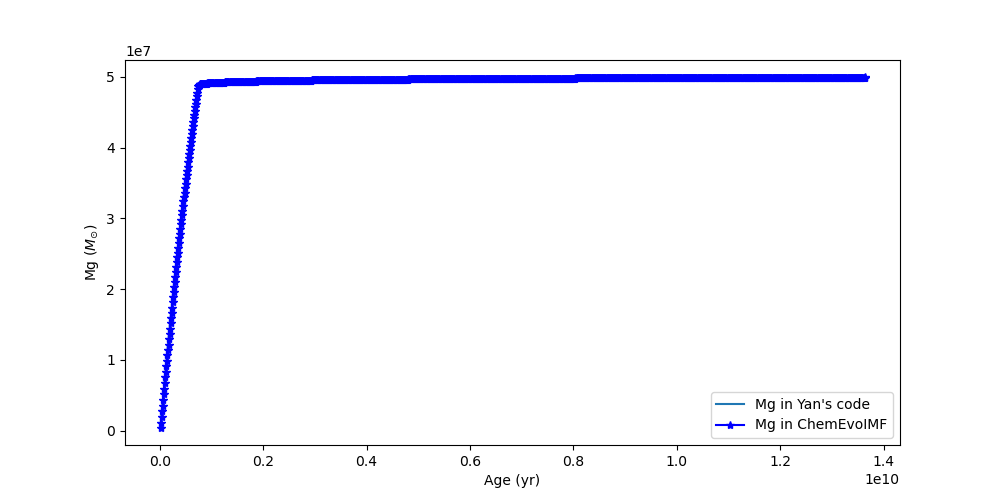

In [17]:
filepath = "../galIMF/simulation_results_from_galaxy_evol/%s/chemical_and_SN_evolution.txt"%dir1
with open(filepath, 'r') as f:
    lines = f.readlines()

Zis = [ ]
Zjs = [ ]
line_num =  [ ]
for i, line in enumerate(lines):
    if "# Gas" in line and "metallicity" not in line:
        elem1, elem2 = re.search(r'\[(\w+)/(\w+)\]', line).groups()
        Zis.append(elem1)
        Zjs.append(elem2)
        line_num.append(i+1)
    elif "time step" in line:
        t = np.array(lines[i+1].split(), dtype=float)
    else:
        pass

Zi = "Mg"
filepath = "../galIMF/simulation_results_from_galaxy_evol/%s/plots/%s.txt" % (dir1, Zi)
with open(filepath, 'r') as f:
    lines = f.readlines()

Zi_arr = { }
Zi_arr[filepath.split("/")[-1].split(".")[0]] = np.array(lines[1].split(), dtype=float)
Zi2Zj.update(GetZi2Zj(GasElement, Zi, "H", solar_set, fill_value=None))
fig, ax = plt.subplots(ncols=1, figsize=(10, 5))
ax.plot(t, Zi_arr[Zi], label="%s in Yan's code"%Zi)
ax.plot(SFH['Age'][Zi2Zj['%s/%s-mask'%(Zi,'H')]], 
        GasElement[Zi2Zj['%s/%s-mask'%(Zi,'H')], constants.elem_names.index(Zi)], 
        'b-*', label='%s in ChemEvoIMF'%Zi)
ax.set_xlabel('Age (yr)')
ax.set_ylabel(r"%s ($M_{\odot}$)"%Zi)
ax.legend()
plt.show()

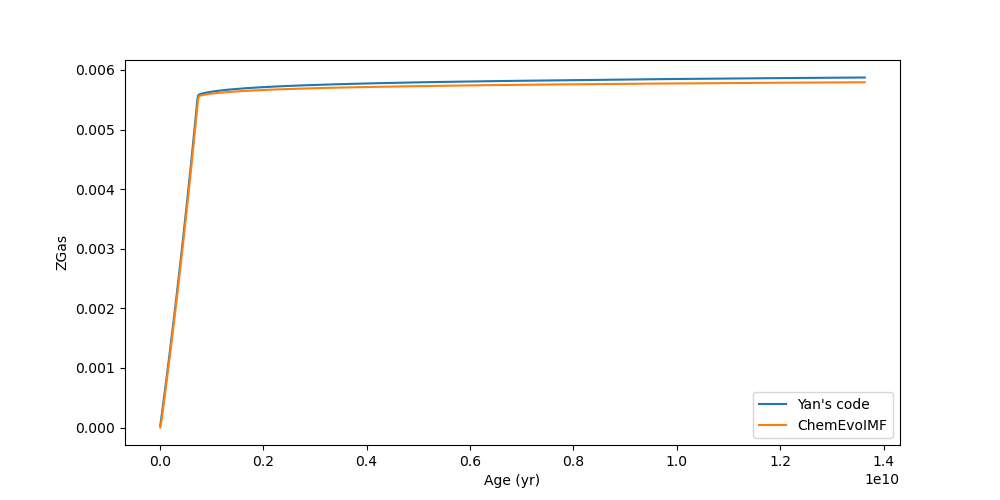

In [18]:
filepath = "../galIMF/simulation_results_from_galaxy_evol/%s/plots/mass_evolution.txt" % (dir1)
with open(filepath, 'r') as f:
    lines = f.readlines()

t = 10**np.array(lines[1].split(), dtype=float)
total_gas_mass = 10**np.array(lines[3].split(), dtype=float)

filepath = "../galIMF/simulation_results_from_galaxy_evol/%s/plots/Metal.txt" % (dir1)
with open(filepath, 'r') as f:
    lines = f.readlines()

total_metal_mass = np.array(lines[1].split(), dtype=float)

fig, ax = plt.subplots(ncols=1, figsize=(10, 5))
ax.plot(t, total_metal_mass/total_gas_mass, label="Yan's code")
ax.plot(SFH['Age'], ZGas, label="ChemEvoIMF")
ax.set_xlabel('Age (yr)')
ax.set_ylabel("ZGas")
ax.legend()
plt.show()

In [19]:
t

array([1.0000e+07, 2.0000e+07, 3.0000e+07, ..., 1.3620e+10, 1.3630e+10,
       1.3634e+10])